# Comparison between ICA and sparse coding

In [1]:
from __future__ import division
import numpy as np
from numpy.linalg import svd,norm,pinv,eig,inv
from sklearn.feature_extraction import image
from h5py import File
from scipy.stats import entropy

from models import ica, sc

import evaluate_degeneracy_controls as dgcs
reload(dgcs)

from utils import tile_raster_images as tri

import matplotlib as mpl
import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline
# Set some default plotting parameters
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.figsize'] = (6, 6)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['legend.fontsize'] = 20

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


# Helper functions

In [2]:
def load_data(filename, key, patch_size, total_samples):
    with File(filename,'r') as f:
        ims = f[key].value
    rng = np.random.RandomState(1234)
    patches = image.PatchExtractor(patch_size=(patch_size, patch_size),\
                               max_patches=total_samples//ims.shape[0],
                               random_state=rng).transform(ims)
    return patches.reshape((patches.shape[0],patch_size**2)).T 

def decorrelate(X):
    d, u = eig(np.cov(X))
    K = np.sqrt(inv(np.diag(d))).dot(u.T)
    X_zca = u.dot(K).dot(X)
    return X_zca

def dist_identity(A,B):
    P = A.dot(B.T)
    P_ = np.zeros_like(P)
    max_idx = np.argmax(abs(P),1)
    P_[np.arange(P.shape[0]),max_idx]=1
    idx = np.argsort(max_idx)
    P_ = P_[idx]
    P = P[idx]
    try:
        return P,P_,norm(P_-np.eye(P_.shape[0])),max_idx 
    except:
        return P,P_,None,max_idx 

def ica_sparsity(W,x):
    return np.log(np.cosh(W.dot(x))).sum(axis=0).mean()

def sc_sparsity(z):
    return abs(z).sum(axis=0).mean()

def kl(a,b):
    return entropy(a,b)

# Generate toy data 

In [72]:
patch_size = 8
total_samples = 50000
rng = np.random.RandomState(1234)
true_oc = 6
dim_input = patch_size**2
dim_sparse = dim_input*true_oc
initial_conditions = ['random']
degeneracy_control = ['L2']


#generate dictionary
W, _ = dgcs.evaluate_dgcs(initial_conditions, degeneracy_control,
                             dim_sparse, dim_input)
W = np.squeeze(W)
A = pinv(W)

#generate sources
S = rng.laplace(0,1e3,size=(dim_sparse,total_samples))

gram_diff = W.dot(W.T)-np.eye(W.shape[0])
mu = abs(gram_diff).max()

k = 20
if k>mu:
    print "\nWarning: k>mu: mu=%s"%str(mu)
    print "Expected k<= %s"%str(1 + mu**(-1))
    k=int(np.floor(1 + mu**(-1)))
    print "New k=%i"%k

if k is not None:
    for ii in range(total_samples):
        #zero = rng.permutation(dim_sparse)[:dim_sparse-k]
        #S[zero, ii] = 0.
        S[np.argsort(abs(S[:,ii]))[:-k],ii]=0

S /= S.std(axis=-1,keepdims=True)

#generate data
X = A.dot(S)

#preprocess data
X_mean = X.mean(axis=-1, keepdims=True)
X -= X_mean
X_zca = decorrelate(X)

Random seed: 46582
Overcomplete ICA
Degeneracy control: L2
Loss: 1056.84301758, Error: 1056.84301758, Penalty: 0.0, MSE: 0.0759284049273
Loss: 962.45715332, Error: 962.45715332, Penalty: 0.0, MSE: 0.00190018140711
Loss: 960.03125, Error: 960.03125, Penalty: 0.0, MSE: 2.98885588563e-05
Loss: 960.001525879, Error: 960.001525879, Penalty: 0.0, MSE: 1.28807528199e-06
Loss: 959.99987793, Error: 959.99987793, Penalty: 0.0, MSE: 1.84812343207e-08
Loss: 959.99987793, Error: 959.99987793, Penalty: 0.0, MSE: 1.84814670234e-08
ICA with L-BFGS-B done!
Final loss value: 959.99987793

Expected k<= 3.17857778414
New k=3


Inspect source distribution

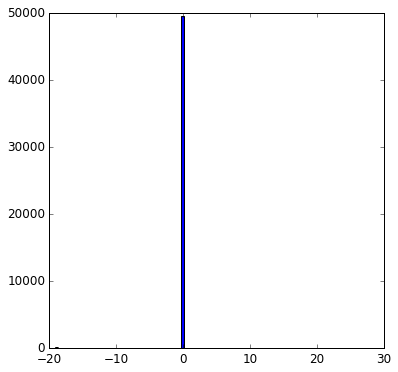

In [73]:
_ = plt.hist(S[0],100)

# Sparse coding

In [75]:
est_oc = true_oc
dim_sparse = dim_input*est_oc
lambd = 1.
sc_model = sc.SparseCoding(n_mixtures=dim_input,
                           n_sources=dim_sparse,
                           lambd=lambd)

Random seed: 68776
Overcomplete SC


In [76]:
sc_model.fit(X_zca)

Loss: 22.9298400879, Error: 9.74056053162, Penalty: 13.1892805099, MSE: 0.16716055572
Loss: 21.6928253174, Error: 9.25068473816, Penalty: 12.4421405792, MSE: 0.186237335205
Loss: 20.7633934021, Error: 8.33200073242, Penalty: 12.431391716, MSE: 0.164455771446
Loss: 19.153755188, Error: 7.46337842941, Penalty: 11.6903772354, MSE: 0.16039045155
Loss: 17.8942260742, Error: 6.6233625412, Penalty: 11.2708644867, MSE: 0.144604980946
Loss: 16.3492984772, Error: 5.64225244522, Penalty: 10.7070455551, MSE: 0.124701626599
Loss: 15.2933712006, Error: 4.70834875107, Penalty: 10.5850219727, MSE: 0.0981767624617
Loss: 14.4258356094, Error: 4.02268600464, Penalty: 10.4031496048, MSE: 0.0797304362059
Loss: 13.6395568848, Error: 3.21558189392, Penalty: 10.4239749908, MSE: 0.0547809936106
Loss: 13.2963352203, Error: 2.89283895493, Penalty: 10.4034957886, MSE: 0.0451141744852
Loss: 12.9276638031, Error: 2.48921012878, Penalty: 10.4384536743, MSE: 0.0324755646288
Loss: 12.7338075638, Error: 2.31037425995, 

SparseCoding(a=None, degeneracy=None, lambd=None, learning_rule=None,
       n_mixtures=64, n_sources=384,
       optimizer=<optimizers.sc_optimizers.SC_Soft object at 0x7fdac45e3250>,
       p=None, prior=None, rng=None, w_init=None)

# ICA

In [83]:
degeneracy_control = 'Lp'
p=4
lambd = 100.
ica_model = ica.ICA(n_mixtures=dim_input,n_sources=dim_sparse,lambd=lambd,
                degeneracy=degeneracy_control,p=p)

Random seed: 41098
Overcomplete ICA
Degeneracy control: Lp


In [84]:
ica_model.fit(X_zca)

Loss: 13912.6416016, Error: 27.6241455078, Penalty: 138.85017395, MSE: 0.125530287623
Loss: 13688.6865234, Error: 31.6290607452, Penalty: 136.570571899, MSE: 0.112134002149
Loss: 13486.6337891, Error: 41.7436218262, Penalty: 134.448898315, MSE: 0.108614258468
Loss: 13411.3935547, Error: 46.2706985474, Penalty: 133.651229858, MSE: 0.104104585946
Loss: 13335.0703125, Error: 51.7235641479, Penalty: 132.833465576, MSE: 0.0982711091638
Loss: 13297.2509766, Error: 55.3797607422, Penalty: 132.418716431, MSE: 0.0967100337148
Loss: 13265.8935547, Error: 58.8744430542, Penalty: 132.07019043, MSE: 0.0965924486518
Loss: 13245.2246094, Error: 61.142539978, Penalty: 131.840820312, MSE: 0.094958357513
Loss: 13228.8300781, Error: 62.3884887695, Penalty: 131.664413452, MSE: 0.0927633792162
Loss: 13216.8134766, Error: 62.9257736206, Penalty: 131.538879395, MSE: 0.0909046456218
Loss: 13208.1445312, Error: 63.2593536377, Penalty: 131.448852539, MSE: 0.0896625295281
Loss: 13201.9873047, Error: 63.461723327

ICA(a=None, degeneracy=None, lambd=None, learning_rule=None, n_mixtures=64,
  n_sources=384,
  optimizer=<optimizers.ica_optimizers.LBFGSB object at 0x7fdacf963c90>,
  p=None, prior=None, rng=None, w_init=None)

# Plotting functions

In [17]:
def plot_bases(bases,figsize=None):
    """Plots a basis set
    
    Parameters:
    ----------
    bases : ndarray
           Set of bases.
           Dimension: n_atoms X n_dims
    figname: string, optional
           Name of the figure
    """
    n_pixels = int(np.sqrt(bases.shape[1]))
    n_bases  = int(np.sqrt(bases.shape[0]))
    if figsize is None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=figsize)
    fig.clf()
    ax = plt.axes()
    im = tri(bases,(n_pixels,n_pixels),(n_bases,n_bases),
                (2,2), scale_rows_to_unit_interval=False,
                output_pixel_vals=False)
    ax.imshow(im)
    ax.set_axis_off()
    plt.show()
    
def plot_angleHist(angles,labels,normed=True,ax=None):
    H = []
    if ax is None:
        fig = plt.figure('angle_hist',figsize=(4,4))
        fig.clf()
        ax = plt.axes([.15,.1,.8,.8])
    col = np.linspace(0,1,len(labels))
    for i in xrange(len(labels)):
        H.append(np.histogram(angles[i],np.arange(0,91),normed=normed)[0])
        b = np.arange(1,91)
        if i>0:
            kl_val = kl(H[i],H[0])
            if kl_val==np.inf:
                kl_val = kl(H[0],H[i])
            labels[i]+='; kl: '+str(kl_val)
        ax.plot(b,H[i],drawstyle='steps-pre',color=plt.cm.viridis(col[i]),lw=1.5,label=labels[i])
    ax.set_yscale('log')
    if not normed:
        ax.set_ylabel('Counts')
        ax.set_yticks([1e0,1e2,1e4])
    else:
        ax.set_ylabel('Density',labelpad=-10)
        ax.set_yticks([1e-5,1e0])
        
    ax.yaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.set_xlim(20,90)
    ax.legend(loc='upper left', frameon=False,ncol=1)
    ax.set_xlabel(r'$\theta$',labelpad=0)
    ax.set_xticks([20,55,90])
    plt.show()

def plot_perm(A,B,binary=True,order=True,ax=None,threshold=None):
    if ax is None:
        fig = plt.figure('perm_mat')
        ax = fig.add_subplot(111)
    P = A.dot(B.T)
    P_ = np.zeros_like(P)
    if threshold is None:
        max_idx = np.array([np.arange(P.shape[0]),np.argmax(abs(P),1)])
    else:
        max_idx = np.where(abs(P)>=threshold)
        print len(max_idx[0]), len(np.unique(max_idx[0]))

    if order and threshold is None:
        idx = np.argsort(max_idx)
    else:
        idx = np.arange(P.shape[0])

    if binary:
        P_[max_idx]=1
        im = ax.imshow(P_[idx])
    else:
        im = ax.imshow(P[idx])
    return im

def plot_results(W,ica_bases,sc_bases):
    W_angles = dgcs.compute_angles(W)
    ica_angles = dgcs.compute_angles(ica_bases)
    sc_angles = dgcs.compute_angles(sc_bases)

    fig = plt.figure(figsize=(12,4))
    P1, P_ica, d_ica, _  = dist_identity(W,ica_bases)
    ax1 = fig.add_subplot(131)
    im = ax1.imshow(P1)
    if d_ica is not None:
        #ax1.set_title(r'ICA; $||ord(P)-I||_2$=%.2f'%d_ica)
        ax1.set_title(r'ICA; $\sigma$=%.2f'%P_ica.sum(0).std())

    P2, P_sc, d_sc, _  = dist_identity(W,sc_bases)
    ax2 = fig.add_subplot(132)
    im = ax2.imshow(P2)
    if d_sc is not None:
        #ax2.set_title(r'SC; $||ord(P)-I||_2$=%.2f'%d_sc)
        ax2.set_title(r'SC; $\sigma$=%.2f'%P_sc.sum(0).std())
                      

    ax3 = fig.add_subplot(133)
    plot_angleHist([W_angles,sc_angles,ica_angles],['original','sc','ica'],ax=ax3)
    
def plot_results2(W,ica_bases,sc_bases,threshold=.8):

    W_angles = dgcs.compute_angles(W)
    ica_angles = dgcs.compute_angles(ica_bases)
    sc_angles = dgcs.compute_angles(sc_bases)

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)

    sc_matches = np.unique(np.where(abs(W.dot(sc_bases.T))>threshold)[0])
    ica_matches = np.unique(np.where(abs(W.dot(ica_bases.T))>threshold)[0])   
    all_matches = np.unique(np.hstack([sc_matches,ica_matches]))
    ica_sc_matches = np.intersect1d(sc_matches,ica_matches)
   
    total = [W.shape[0],sc_bases.shape[0],ica_bases.shape[0],ica_bases.shape[0]]
    matches = [len(all_matches), len(sc_matches), len(ica_matches), len(ica_sc_matches)] 
    only = [0, len(sc_matches)-len(ica_sc_matches), len(ica_matches)- len(ica_sc_matches),0]
    
    ind = np.arange(4)    
    width = 0.5       
    
    p1 = ax1.bar(ind, total, width, color='b',alpha=1., label='total')
    p2 = ax1.bar(ind, matches, width, color='r',alpha=1., label='matches')
    p3 = ax1.bar(ind, only, width, color='y',alpha=1., label='only')
    
    ax1.legend(loc='best', frameon=False,ncol=1)
    
    ax1.set_xticks(np.arange(4)+.25)
    ax1.set_xticklabels(['none','sc','ica','sc+ica'])

    ax2 = fig.add_subplot(122)
    plot_angleHist([W_angles,sc_angles,ica_angles],['original','sc','ica'],ax=ax2)


# Results

## 1) Sparse coding with different lambdas on L4 data

In [ ]:
lambd = [.001,.01,.1,1.,10]
angles = [dgcs.compute_angles(W)]
sc_models = []

for i in xrange(len(lambd)):
    sc_models.append(sc.SparseCoding(n_mixtures=dim_input,
                           n_sources=dim_sparse,
                           lambd=lambd[i]))
    sc_models[i].fit(X_zca)
    angles.append(dgcs.compute_angles(sc_models[i].components_))

In [ ]:
plot_angleHist(angles,['original']+lambd)
fig = plt.figure(figsize=(10,10))
for i in xrange(len(lambd)):
    ax = fig.add_subplot(3,2,i+1)
    P,_,d,_ = dist_identity(sc_models[i].components_,W)
    ax.set_title(r'$\lambda=%.2f; ||ord(P)-I||_2$=%.2f'%(lambd[i],d))
    im = plot_perm(sc_models[i].components_,W,ax=ax,binary=False)
    ax.set_axis_off()

## 2) Sparse coding ICA comparison

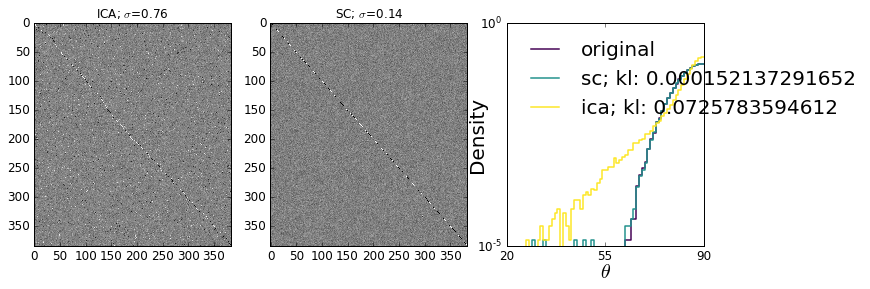

In [85]:
sc_bases = sc_model.components_
ica_bases = ica_model.components_
plot_results(W,ica_bases,sc_bases)

In [ ]:
sc_bases = sc_model.components_
ica_bases = ica_model.components_
plot_results(W,ica_bases,sc_bases)

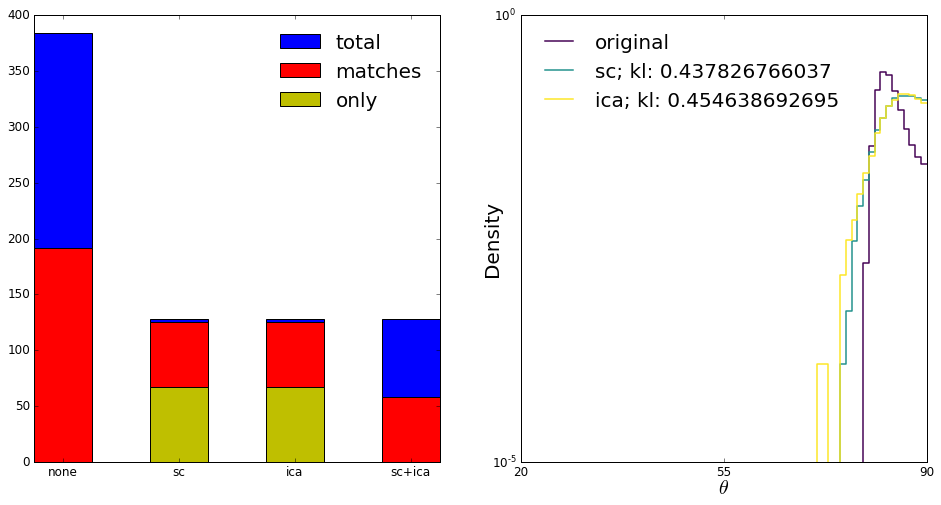

In [71]:
sc_bases = sc_model.components_
ica_bases = ica_model.components_
plot_results2(W,ica_bases,sc_bases)

In [ ]:
Z = W.dot(ica_bases.T)
h = plt.hist(Z.flatten(),100)

In [ ]:
Z = W.dot(sc_bases.T)
h = plt.hist(Z.flatten(),100)

In [ ]:
Z = ica_bases.dot(sc_bases.T)
h = plt.hist(Z.flatten(),100)